In [1]:
!pip install segmentation-models-pytorch

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 55.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 59.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.1/8.1 MB 62.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 899.7/899.7 MB 16.2 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 594.3/594.3 MB 23.7 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.2/10.2 MB 45.8 MB/s eta 0:00:00:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.0/88.0 MB 65.8 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 954.8/954.8 kB 43.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 706.8/706.8 MB 24.1 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.1/193.1 MB 51.3 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 46.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.6/63.6 MB 38.4 MB/s eta 0

In [2]:
!pip install torchinfo


[notice] A new release of pip is available: 25.1.1 -> 25.3
[notice] To update, run: python3 -m pip install --upgrade pip


In [11]:
# Import Required Libraries:
import os
import random
import numpy as np
import matplotlib.pyplot as plt

# Image manipulation
from PIL import Image

# PyTorch libraries
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import torchvision
import torch.nn.functional as F
import torch.optim as optim
from torchinfo import summary
from torch.optim.lr_scheduler import ReduceLROnPlateau

#import albumentations as A
#from albumentations.pytorch import ToTensorV2

from tqdm.auto import tqdm

import segmentation_models_pytorch as smp
from segmentation_models_pytorch.losses import DiceLoss, JaccardLoss

#from skimage.io import imread
#from skimage.transform import resize
import os
torch.manual_seed(42)
np.random.seed(42)

from sklearn.model_selection import train_test_split

/usr/local/python/3.12.1/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [7]:
#Dataset already split into train and test datasets - Train dataset + Train ground truth, Test dataset + Test ground truth

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [1]:
import os

# relative paths:
training_data_path = 'ISBI2016_ISIC_Part1_Training_Data'
training_masks_path = 'ISBI2016_ISIC_Part1_Training_GroundTruth'


image_files = os.listdir(training_data_path)
mask_files = os.listdir(training_masks_path)

print(f"Found {len(image_files)} training images.")
print(f"Found {len(mask_files)} training masks.")

# print the first few to check:
print("\nFirst 5 images:", image_files[:5])
print("First 5 masks:", mask_files[:5])

Found 164 training images.
Found 1027 training masks.

First 5 images: ['ISIC_0000146.jpg', 'ISIC_0000089.jpg', 'ISIC_0002879.jpg', 'ISIC_0008403.jpg', 'ISIC_0002647.jpg']
First 5 masks: ['ISIC_0000358_Segmentation (1).png', 'ISIC_0010222_Segmentation.png', 'ISIC_0006350_Segmentation.png', 'ISIC_0010339_Segmentation (1).png', 'ISIC_0009944_Segmentation.png']


In [4]:
import os

# The folders are the paths, so just assign the names directly
img_path_train = 'ISBI2016_ISIC_Part1_Training_Data'
mask_path_train = 'ISBI2016_ISIC_Part1_Training_GroundTruth'
img_path_test = 'ISBI2016_ISIC_Part1_Test_Data'
mask_path_test = 'ISBI2016_ISIC_Part1_Test_GroundTruth'


# Let's test them to make sure they work:
print(f"Training images path: {img_path_train}")
print(f"Files found: {len(os.listdir(img_path_train))}")
print(f"Test images path: {img_path_test}")
print(f"Files found: {len(os.listdir(img_path_test))}")

Training images path: ISBI2016_ISIC_Part1_Training_Data
Files found: 164
Test images path: ISBI2016_ISIC_Part1_Test_Data
Files found: 56


In [5]:
train_size = 0.8
lr = 5e-4
weight_decay = 8e-9
batch_size = 16
epochs = 50
size = (128, 128)

In [6]:
train_image_files = os.listdir(img_path_train)
train_mask_files = os.listdir(mask_path_train)

In [9]:
import random

n = 3  # Number of image-mask pairs to plot
samples_n = min(n, len(train_image_files))  # Ensure n doesn't exceed available files

# random samples from train data
random_indices = random.sample(range(len(train_image_files)), samples_n)

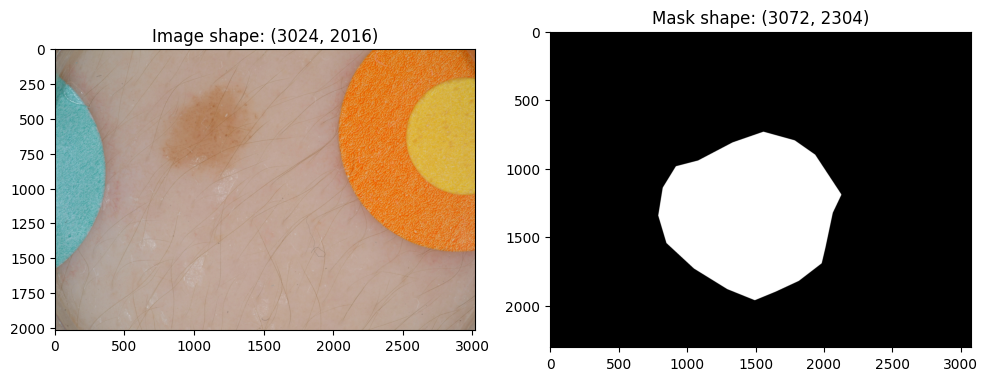

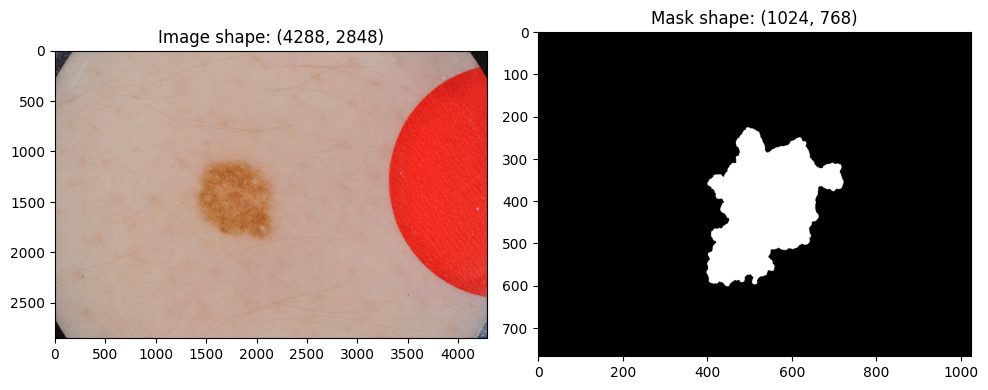

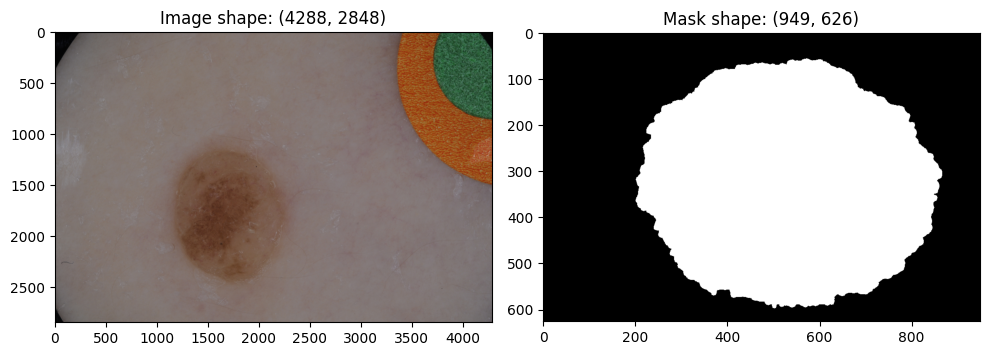

In [12]:
#Plot data from the train dataset
for i in random_indices:
    # Create full paths
    img_path = os.path.join(img_path_train, train_image_files[i])
    mask_path = os.path.join(mask_path_train, train_mask_files[i])

    # Load image and mask (using PIL)
    image = Image.open(img_path)
    mask = Image.open(mask_path)

    # Extract the shape of the image
    image_shape = image.size
    mask_shape = mask.size

    # Convert to np arrays for visualisation
    array_image = np.array(image)
    array_mask = np.array(mask)


    plt.figure(figsize=(10, 5))

    plt.subplot(1, 2, 1)
    plt.imshow(array_image)
    plt.title(f"Image shape: {image_shape}")

    plt.subplot(1, 2, 2)
    plt.imshow(array_mask, cmap='grey') # Using 'grey' since training ground truth provided in greyscale
    plt.title(f"Mask shape: {mask_shape}")

    plt.tight_layout()
    plt.show()

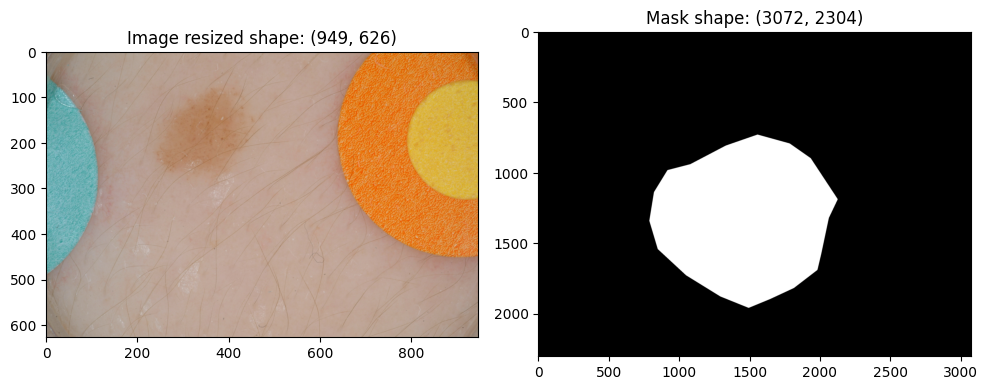

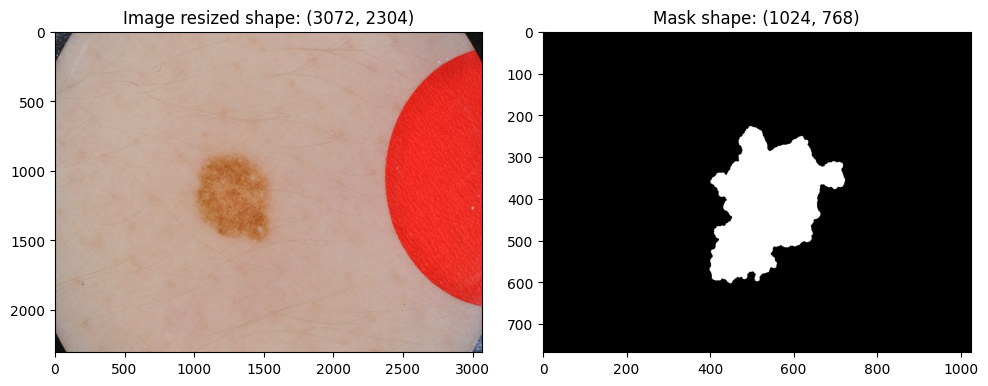

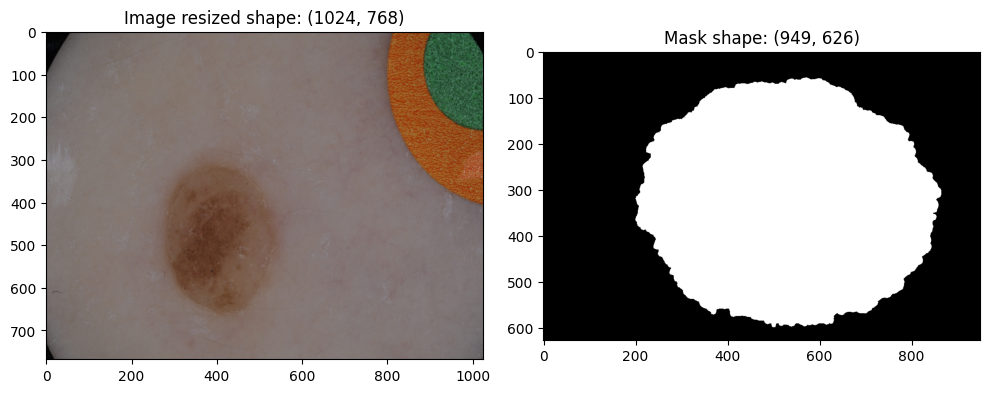

In [13]:
#Resize the image to match the mask shape and plot data from the train dataset
for i in random_indices:
    # Create full paths
    img_path = os.path.join(img_path_train, train_image_files[i])
    mask_path = os.path.join(mask_path_train, train_mask_files[i])

    # Load image and mask (using PIL)
    image = Image.open(img_path)
    mask = Image.open(mask_path)

    # Resize the image
    image_resized = image.resize(mask_shape)

    # Convert to np arrays for visualisation
    array_image_resized = np.array(image_resized)
    array_mask = np.array(mask)

    # Extract the shape of the image
    image_shape_resized = image_resized.size
    mask_shape = mask.size


    plt.figure(figsize=(10, 5))

    plt.subplot(1, 2, 1)
    plt.imshow(array_image_resized)
    plt.title(f"Image resized shape: {image_shape_resized}")

    plt.subplot(1, 2, 2)
    plt.imshow(array_mask, cmap='grey') # Using 'grey' since training ground truth provided in greyscale
    plt.title(f"Mask shape: {mask_shape}")

    plt.tight_layout()
    plt.show()

In [14]:
# Custom dataset to handle loading images and masks
class LoadDataset(Dataset):
  def __init__(self, image_paths, mask_paths, transform=None, mask_transform=None):
    self.image_paths = image_paths
    self.mask_paths = mask_paths
    self.transform = transform
    self.transform_mask = mask_transform
    self.images = os.listdir(image_paths)
    self.masks = os.listdir(mask_paths)

  def __len__(self):
    return len(self.images)

  def __getitem__(self, index):
    image_path = os.path.join(self.image_paths, self.images[index])
    mask_path = os.path.join(self.mask_paths, self.masks[index])


    image = Image.open(image_path).convert('RGB')
    mask = Image.open(mask_path).convert('L')

    if self.transform:
      image = self.transform(image)
    if self.transform_mask:
      mask = self.transform_mask(mask)

    return image, mask

In [15]:
img_transforms = transforms.Compose([
    transforms.Resize(size),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])])

mask_transforms = transforms.Compose([
    transforms.Resize(size),
    transforms.ToTensor()
])

In [16]:
# Create an instance of your LoadDataset
dataset = LoadDataset(img_path_train, mask_path_train, transform=img_transforms, mask_transform=mask_transforms)

# Get a sample (e.g., the first image-mask pair)
image, mask = dataset[90]

print("Image shape:", image.shape)
print("Mask shape:", mask.shape)

Image shape: torch.Size([3, 128, 128])
Mask shape: torch.Size([1, 128, 128])


In [17]:
#create general train and test datasets
train_dataset = LoadDataset(img_path_train, mask_path_train, transform=img_transforms, mask_transform=mask_transforms)
test_dataset = LoadDataset(img_path_test, mask_path_test, transform=img_transforms, mask_transform=mask_transforms)

In [18]:
#create train and test dataloaders
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True) #shuffle true, model sees the data in a random order every epoch, prevents model from memorizing the order - learns real patterns, helps generalization
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False) #shuffle false, allows for evaluating the model in a consistent way

In [21]:
class SegNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.enc_conv0 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=(3,3), padding=1)
        self.act0 = nn.ReLU()
        self.bn0 = nn.BatchNorm2d(16)
        self.pool0 = nn.MaxPool2d(kernel_size=(2,2))

        self.enc_conv1 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=(3,3), padding=1)
        self.act1 = nn.ReLU()
        self.bn1 = nn.BatchNorm2d(32)
        self.pool1 = nn.MaxPool2d(kernel_size=(2,2))

        self.enc_conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(3,3), padding=1)
        self.act2 = nn.ReLU()
        self.bn2 = nn.BatchNorm2d(64)
        self.pool2 =  nn.MaxPool2d(kernel_size=(2,2))

        self.enc_conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=(3,3), padding=1)
        self.act3 = nn.ReLU()
        self.bn3 = nn.BatchNorm2d(128)
        self.pool3 =  nn.MaxPool2d(kernel_size=(2,2))

        self.bottleneck_conv = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=(3,3), padding=1)

        self.upsample0 =  nn.UpsamplingBilinear2d(scale_factor=2)
        self.dec_conv0 = nn.Conv2d(in_channels=256, out_channels=128, kernel_size=(3,3), padding=1)
        self.dec_act0 = nn.ReLU()
        self.dec_bn0 = nn.BatchNorm2d(128)

        self.upsample1 =  nn.UpsamplingBilinear2d(scale_factor=2)
        self.dec_conv1 =  nn.Conv2d(in_channels=128, out_channels=64, kernel_size=(3,3), padding=1)
        self.dec_act1 = nn.ReLU()
        self.dec_bn1 = nn.BatchNorm2d(64)

        self.upsample2 = nn.UpsamplingBilinear2d(scale_factor=2)

        self.dec_conv2 = nn.Conv2d(in_channels=64, out_channels=32, kernel_size=(3,3), padding=1)
        self.dec_act2 = nn.ReLU()
        self.dec_bn2 = nn.BatchNorm2d(32)

        self.upsample3 = nn.UpsamplingBilinear2d(scale_factor=2)
        self.dec_conv3 = nn.Conv2d(in_channels=32, out_channels=1, kernel_size=(1,1))

        #self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        e0 = self.pool0(self.bn0(self.act0(self.enc_conv0(x))))
        e1 = self.pool1(self.bn1(self.act1(self.enc_conv1(e0))))
        e2 = self.pool2(self.bn2(self.act2(self.enc_conv2(e1))))
        e3 = self.pool3(self.bn3(self.act3(self.enc_conv3(e2))))

        b = self.bottleneck_conv(e3)

        d0 = self.dec_bn0(self.dec_act0(self.dec_conv0(self.upsample0(b))))
        d1 = self.dec_bn1(self.dec_act1(self.dec_conv1(self.upsample1(d0))))
        d2 = self.dec_bn2(self.dec_act2(self.dec_conv2(self.upsample2(d1))))
        d3 = self.dec_conv3(self.upsample3(d2))
        return d3


In [22]:
import torch
import torch.nn as nn
import torch.optim as optim

# This is what fixes your 'device' error
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print(f"Using device: {device}")

Using device: cpu


In [23]:
#Parameters
lr = 5e-4
weight_decay = 8e-9
batch_size = 16
epochs = 50

# Model with Adam optimizer
model_v1 = SegNet().to(device) # Move model to the device (GPU if available)
optimizer = optim.Adam(model_v1.parameters(), lr=lr, weight_decay=weight_decay)
loss_fn = nn.BCEWithLogitsLoss() # Use PyTorch's Binary Cross Entropy Loss

# Training loop
for epoch in range(epochs):
  model_v1.train()
  running_loss = 0.0

  for batch_idx, (data, target) in enumerate(train_dataloader):
        data, target = data.to(device), target.to(device)  # Move data to device

        optimizer.zero_grad() # Reset gradients
        output = model_v1(data.float()) # Forward pass

        loss = loss_fn(output, target.float()) # Calculate loss
        loss.backward() # Backward pass
        optimizer.step() # Update weights

        running_loss += loss.item() #Accumulate loss

        #binary predictions based on probabilities - use sigmoid funct to get them
        probabilities = torch.sigmoid(output)
        predictions = (probabilities >0.5).float()

        #number of correct predictions
        correct_preds = (predictions == target).float().sum()
        accuracy = correct_preds / target.numel() #.numel() returns size of the tensor





        # Print progress (optional) Prints every 8 batches
        if batch_idx % 2 == 0:
            print(f'Epoch: {epoch+1}, Batch: {batch_idx}, Loss: {loss.item()}, Accuracy: {accuracy}')

Epoch: 1, Batch: 0, Loss: 0.7326403856277466, Accuracy: 0.4877891540527344
Epoch: 1, Batch: 2, Loss: 0.6600225567817688, Accuracy: 0.5937309265136719
Epoch: 1, Batch: 4, Loss: 0.6487106680870056, Accuracy: 0.6516799926757812
Epoch: 1, Batch: 6, Loss: 0.634796679019928, Accuracy: 0.6356124877929688
Epoch: 1, Batch: 8, Loss: 0.6159605979919434, Accuracy: 0.6856002807617188
Epoch: 1, Batch: 10, Loss: 0.6393533945083618, Accuracy: 0.6788787841796875
Epoch: 2, Batch: 0, Loss: 0.6354113817214966, Accuracy: 0.6728172302246094
Epoch: 2, Batch: 2, Loss: 0.5913264751434326, Accuracy: 0.6826553344726562
Epoch: 2, Batch: 4, Loss: 0.5983864665031433, Accuracy: 0.6709938049316406
Epoch: 2, Batch: 6, Loss: 0.6033568382263184, Accuracy: 0.6957206726074219
Epoch: 2, Batch: 8, Loss: 0.5403841733932495, Accuracy: 0.7408485412597656
Epoch: 2, Batch: 10, Loss: 0.5472995638847351, Accuracy: 0.7535858154296875
Epoch: 3, Batch: 0, Loss: 0.6724607348442078, Accuracy: 0.6409225463867188
Epoch: 3, Batch: 2, Loss

KeyboardInterrupt: 

Really bad results, low accuracy. Try U-Net

In [24]:
#U-Net model - encoder-decoder model

class UNet(nn.Module):
  def __init__(self, in_channels=3, out_channels=1):
    super(UNet, self).__init__()

    # Encoder part
    self.encoder1 = self.contracting_block(in_channels, 64)
    self.encoder2 = self.contracting_block(64, 128)
    self.encoder3 = self.contracting_block(128, 256)

    # Bottleneck
    self.bottleneck = self.contracting_block(256, 512)

    # Decoder part
    self.decoder3 = self.expansive_block(512, 256)
    self.decoder2 = self.expansive_block(512, 128)
    self.decoder1 = self.expansive_block(256, 64)

    # Final output layer
    self.final_output = nn.Conv2d(128, out_channels, kernel_size=1)

  def contracting_block(self, in_channels, out_channels):
    block = nn.Sequential(
        nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
        nn.BatchNorm2d(out_channels),
        nn.ReLU(inplace=True),
        nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
        nn.BatchNorm2d(out_channels),
        nn.ReLU(inplace=True),
    )
    return block

  def expansive_block(self, in_channels, out_channels):
    block = nn.Sequential(
        nn.ConvTranspose2d(in_channels, out_channels, kernel_size=2, stride=2),
        nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
        nn.BatchNorm2d(out_channels),
        nn.ReLU(inplace=True),
        nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
        nn.BatchNorm2d(out_channels),
        nn.ReLU(inplace=True),
    )
    return block

  def forward(self, x):
    encoder1 = self.encoder1(x)
    encoder2 = self.encoder2(nn.MaxPool2d(2)(encoder1))
    encoder3 = self.encoder3(nn.MaxPool2d(2)(encoder2))

    bottleneck = self.bottleneck(nn.MaxPool2d(2)(encoder3))

    decoder3 = self.decoder3(bottleneck)
    decoder3 = torch.cat([encoder3, decoder3], dim=1)

    decoder2 = self.decoder2(decoder3)
    decoder2 = torch.cat([encoder2, decoder2], dim=1)

    decoder1 = self.decoder1(decoder2)
    decoder1 = torch.cat([encoder1, decoder1], dim=1)

    out = self.final_output(decoder1)

    return out


In [25]:
#early stop to prevent overfitting
class EarlyStop:
  def __init__(self, patience=5, min_delta=0):
    self.patience = patience
    self.min_delta = min_delta
    self.counter = 0
    self.best_loss = None
    self.early_stop = False

  def __call__(self, val_loss):
    if self.best_loss is None:
      self.best_loss = val_loss
    elif self.best_loss < self.best_loss - self.min_delta:
      self.best_loss = val_loss
      self.counter = 0
    else:
      self.counter += 1
      if self.counter >= self.patience:
        self.early_stop = True

In [26]:
#Parameters
lr = 5e-4
weight_decay = 8e-9
batch_size = 16
epochs = 50


model_v2_unet = UNet(in_channels=3, out_channels=1).to(device)
optimizer = optim.Adam(model_v2_unet.parameters(), lr=lr, weight_decay=weight_decay)
loss_fn = nn.BCEWithLogitsLoss()

early_stop = EarlyStop(patience=4, min_delta=0)

# Training loop
for epoch in range(epochs):
  model_v2_unet.train()
  running_loss = 0.0

  for batch_idx, (data, target) in enumerate(train_dataloader):
        data, target = data.to(device), target.to(device)  # Move data to device

        optimizer.zero_grad() # Reset gradients
        output = model_v2_unet(data.float()) # Forward pass

        loss = loss_fn(output, target.float()) # Calculate loss
        loss.backward() # Backward pass
        optimizer.step() # Update weights

        running_loss += loss.item() #Accumulate loss

        #binary predictions based on probabilities - use sigmoid funct to get them
        probabilities = torch.sigmoid(output)
        predictions = (probabilities >0.5).float()

        #number of correct predictions
        correct_preds = (predictions == target).float().sum()
        accuracy = correct_preds / target.numel() #.numel() returns size of the tensor





        # Print progress (optional) Prints every 2 batches
        if batch_idx % 2 == 0:
            print(f'Epoch: {epoch+1}, Batch: {batch_idx}, Loss: {loss.item()}, Accuracy: {accuracy}')

  # Average training loss to trigger early stop and prevent overfitting
  avg_train_loss = running_loss / len(train_dataloader)

  early_stop(avg_train_loss)

  if early_stop.early_stop:
    print("Early stopping has been triggered")
    break

Epoch: 1, Batch: 0, Loss: 0.7428086400032043, Accuracy: 0.43235015869140625
Epoch: 1, Batch: 2, Loss: 0.5942662954330444, Accuracy: 0.6982307434082031


: 

Early stop with patience 4 triggered too soon. Will try to lower the patience to prevent underfitting.

In [2]:
#Parameters
lr = 5e-4
weight_decay = 8e-9
batch_size = 16
epochs = 50


model_v2_unet = UNet(in_channels=3, out_channels=1).to(device)
optimizer = optim.Adam(model_v2_unet.parameters(), lr=lr, weight_decay=weight_decay)
loss_fn = nn.BCEWithLogitsLoss()

early_stop = EarlyStop(patience=3, min_delta=0)

# Training loop
for epoch in range(epochs):
  model_v2_unet.train()
  running_loss = 0.0

  for batch_idx, (data, target) in enumerate(train_dataloader):
        data, target = data.to(device), target.to(device)  # Move data to device

        optimizer.zero_grad() # Reset gradients
        output = model_v2_unet(data.float()) # Forward pass

        loss = loss_fn(output, target.float()) # Calculate loss
        loss.backward() # Backward pass
        optimizer.step() # Update weights

        running_loss += loss.item() #Accumulate loss

        #binary predictions based on probabilities - use sigmoid funct to get them
        probabilities = torch.sigmoid(output)
        predictions = (probabilities >0.5).float()

        #number of correct predictions
        correct_preds = (predictions == target).float().sum()
        accuracy = correct_preds / target.numel() #.numel() returns size of the tensor





        # Print progress (optional) Prints every 2 batches
        if batch_idx % 2 == 0:
            print(f'Epoch: {epoch+1}, Batch: {batch_idx}, Loss: {loss.item()}, Accuracy: {accuracy}')

  # Average training loss to trigger early stop and prevent overfitting
  avg_train_loss = running_loss / len(train_dataloader)

  early_stop(avg_train_loss)

  if early_stop.early_stop:
    print("Early stopping has been triggered")
    break

NameError: name 'UNet' is not defined

Early stop triggered due to following accuracy. For more accurate results, I will monitor validation accuracy instead.

In [ ]:
#Parameters
lr = 5e-4
weight_decay = 8e-9
batch_size = 16
epochs = 50


model_v2_unet = UNet(in_channels=3, out_channels=1).to(device)
optimizer = optim.Adam(model_v2_unet.parameters(), lr=lr, weight_decay=weight_decay)
loss_fn = nn.BCEWithLogitsLoss()

early_stop = EarlyStop(patience=4, min_delta=0.001) #changed patience 3->4, and min_delta 0.001

# Training loop
for epoch in range(epochs):
  model_v2_unet.train()
  running_loss = 0.0

  for batch_idx, (data, target) in enumerate(train_dataloader):
        data, target = data.to(device), target.to(device)  # Move data to device

        optimizer.zero_grad() # Reset gradients
        output = model_v2_unet(data.float()) # Forward pass

        loss = loss_fn(output, target.float()) # Calculate loss
        loss.backward() # Backward pass
        optimizer.step() # Update weights

        running_loss += loss.item() #Accumulate loss

        #binary predictions based on probabilities - use sigmoid funct to get them
        probabilities = torch.sigmoid(output)
        predictions = (probabilities >0.5).float()

        #number of correct predictions
        correct_preds = (predictions == target).float().sum()
        accuracy = correct_preds / target.numel() #.numel() returns size of the tensor





        # Print progress (optional) Prints every 2 batches
        if batch_idx % 2 == 0:
            print(f'Epoch: {epoch+1}, Batch: {batch_idx}, Loss: {loss.item()}, Accuracy: {accuracy}')
  # Validation
  model_v2_unet.eval()
  running_val_loss = 0.0
  running_val_accuracy = 0.0

  with torch.no_grad():
    for val_data, val_target in test_dataloader:
      val_data, val_target = val_data.to(device), val_target.to(device)
      val_output = model_v2_unet(val_data.float())
      val_loss = loss_fn(val_output, val_target.float())
      running_val_loss += val_loss.item()

      probabilities = torch.sigmoid(val_output)
      val_predictions = (probabilities > 0.5).float()
      val_correct_preds = (val_predictions == val_target).float().sum()
      val_accuracy = val_correct_preds / val_target.numel()

      running_val_accuracy += val_accuracy.item()

      # Print validation metrics
    avg_val_loss = running_val_loss / len(test_dataloader)
    avg_val_accuracy = running_val_accuracy / len(test_dataloader)
    print(f'Validation Loss: {avg_val_loss}, Validation Accuracy: {avg_val_accuracy}')

  # Average training loss to trigger early stop and prevent overfitting
  #avg_train_loss = running_loss / len(train_dataloader)

  early_stop(val_loss=avg_val_loss)

  if early_stop.early_stop:
    print("Early stopping has been triggered")
    break

In [ ]:
#visualise predictions to find errors that might cause early stopping at such early stage
def visual_preds(model, dataloader, device, num_samples=5):
  model.eval()
  samples = 0

  with torch.no_grad():
    for data, target in dataloader:
      data, target = data.to(device), target.to(device)
      output = model(data.float())
      prediction = torch.sigmoid(output)
      prediction = (prediction > 0.5).float()

      for i in range(data.size(0)):
        if samples >= num_samples:
          return

        img = data[i].cpu().permute(1, 2, 0)  # CHW -> HWC
        mask = target[i].cpu().squeeze()     # Ground truth mask
        pred_mask = prediction[i].cpu().squeeze()  # Predicted mask

        fig, axs = plt.subplots(1, 3, figsize=(12, 4))
        axs[0].imshow(img)
        axs[0].set_title('Input Image')
        axs[0].axis('off')

        axs[1].imshow(mask, cmap='gray')
        axs[1].set_title('Ground Truth')
        axs[1].axis('off')

        axs[2].imshow(pred_mask, cmap='gray')
        axs[2].set_title('Prediction')
        axs[2].axis('off')

        plt.tight_layout()
        plt.show()

        samples += 1



In [ ]:
visual_preds(model_v2_unet, test_dataloader, device, num_samples=5)

Prediction mask over-segmented the lesion. It might be that the background is predicted as part of the lesion - false positives.
- Will try to use dice loss

[Medium Dice Loss](https://medium.com/data-scientists-diary/implementation-of-dice-loss-vision-pytorch-7eef1e438f68)

In [ ]:
def dice_loss(predictions, targets, smooth=1):
  predictions = torch.sigmoid(predictions)
  predictions = predictions.view((predictions.size(0),-1)) # this flattens predictions
  targets = targets.view(targets.size(0),-1)

  intersection = (predictions * targets).sum(dim=1)
  union = predictions.sum(dim=1) + targets.sum(dim=1)

  dice = (2.0 * intersection + smooth) / (union + smooth)
  dice_loss = 1 - dice

  return dice_loss.mean() #mean dice loss for batches

In [ ]:
#Parameters
lr = 5e-4
weight_decay = 8e-9
batch_size = 16
epochs = 50


model_v2_unet = UNet(in_channels=3, out_channels=1).to(device)
optimizer = optim.Adam(model_v2_unet.parameters(), lr=lr, weight_decay=weight_decay)
bce_loss_fn = nn.BCEWithLogitsLoss()
dice_loss_fn = dice_loss

early_stop = EarlyStop(patience=4, min_delta=0.001) #changed patience 3->4, and min_delta 0.001

# initialise best validation loss
best_val_loss = float('inf') #'inf' sets val_loss value as infinite value, allowing for best value to be saved
# Training loop
for epoch in range(epochs):
  model_v2_unet.train()
  running_loss = 0.0

  for batch_idx, (data, target) in enumerate(train_dataloader):
        data, target = data.to(device), target.to(device)  # Move data to device

        optimizer.zero_grad() # Reset gradients
        output = model_v2_unet(data.float()) # Forward pass

        bce = bce_loss_fn(output, target.float())
        dice = dice_loss_fn(output, target.float())
        loss = bce + dice # Calculate loss

        loss.backward() # Backward pass
        optimizer.step() # Update weights

        running_loss += loss.item() #Accumulate loss

        #binary predictions based on probabilities - use sigmoid funct to get them
        probabilities = torch.sigmoid(output)
        predictions = (probabilities >0.6).float() #adjust from 0.5 to 0.6

        #number of correct predictions
        correct_preds = (predictions == target).float().sum()
        accuracy = correct_preds / target.numel() #.numel() returns size of the tensor





        # Print progress (optional) Prints every 2 batches
        if batch_idx % 2 == 0:
            print(f'Epoch: {epoch+1}, Batch: {batch_idx}, BCE: {bce.item()}, Dice: {dice.item()}, Final Loss: {loss.item()}, Accuracy: {accuracy}')
  # Validation
  model_v2_unet.eval()
  running_val_loss = 0.0
  running_val_accuracy = 0.0

  with torch.no_grad():
    for val_data, val_target in test_dataloader:
      val_data, val_target = val_data.to(device), val_target.to(device)
      val_output = model_v2_unet(val_data.float())
      val_loss = loss_fn(val_output, val_target.float())
      running_val_loss += val_loss.item()

      probabilities = torch.sigmoid(val_output)
      val_predictions = (probabilities > 0.5).float()
      val_correct_preds = (val_predictions == val_target).float().sum()
      val_accuracy = val_correct_preds / val_target.numel()

      running_val_accuracy += val_accuracy.item()

      # Print validation metrics
    avg_val_loss = running_val_loss / len(test_dataloader)
    avg_val_accuracy = running_val_accuracy / len(test_dataloader)
    print(f'Validation Loss: {avg_val_loss}, Validation Accuracy: {avg_val_accuracy}')

    # Save the best model before early stopping is triggered
    if avg_val_loss < best_val_loss:
      best_val_loss = avg_val_loss
      torch.save(model_v2_unet.state_dict(), 'best_model_v2_unet.pth')

  # Average training loss to trigger early stop and prevent overfitting
  #avg_train_loss = running_loss / len(train_dataloader)

  early_stop(val_loss=avg_val_loss)

  if early_stop.early_stop:
    print("Early stopping has been triggered")
    break

In [ ]:
#Load your best model
model_v2_unet.load_state_dict(torch.load('best_model_v2_unet.pth'))
model_v2_unet.eval()

In [ ]:
visual_preds(model_v2_unet, test_dataloader, device, num_samples=15)

In [ ]:
# Calculate Intersection over Union (IoU) to
import torch

def calculate_iou(predictions, targets):
  intersection = torch.logical_and(predictions, targets).sum()
  union = torch.logical_or(predictions, targets).sum()
  iou = (intersection + 1e-6) / (union + 1e-6)
  return iou

def calculate_average_iou(model, dataloader, device, threshold=0.5):
  model.eval()  # Set model to evaluation mode
  total_iou = 0
  num_images = 0

  with torch.no_grad():  # Disable gradient calculation
    for batch_idx, (data, targets) in enumerate(dataloader):
      data, targets = data.to(device), targets.to(device)

      # Get predictions (assuming sigmoid activation is already applied)
      predictions = model(data)
      predictions = (predictions > threshold).float()

      # Calculate IoU for each image in the batch
      for i in range(data.shape[0]):
        iou = calculate_iou(predictions[i], targets[i])
        total_iou += iou.item()
        num_images += 1

  average_iou = total_iou / num_images
  return average_iou

# Example usage
average_iou = calculate_average_iou(model_v2_unet, test_dataloader, device)
print(f"Average IoU: {average_iou:.4f}")

IoU ranges from 0 to 1 so IoU=0.4675 tells us the model is performing poorly - it's not identifying the object well. Meaning there is not enough overlap between prediction and ground truth.

For this task I've chosen the U-Net model with encoder-decoder structure and skip connections. I've included contracting block, bottleneck and expansive block to encode and decode the data. In each expansive block i've used transposed convolution that upsamples the feature maps. The final output is a segmentation mask.
Batch normalization and ReLU activation was used to improve the performance.

With the early_stop monitoring the validation loss I was able to save the best model in the training stage - model_v2_unet.

However the models predictions were not as good as expected.

I've investigated Intersection over Union (IoU) and low score of 0.4675 shows that the model is not identifying the object well.

Score that'd be good enough for the data would be at least over 0.5 since the range of the scores is 0 to 1.

Looking at the predictions we can see that the models is good at identifiying larger structures but struggles with more details.

The prediction shaped are quite blocky which leads me to believe that there isn't enough contrast on the pictures in the dataset and the model struggles to differentiate between lesion and background.
This may be due to dataset quality. Images with higher contrast should be included in training in order to improve the performance.

Even though U-Net is a popular network used for image segmentation, maybe more sophisticated network such as VGG-UNet should be used. In the [Automated Skin Lesion Segmentation using VGG-UNet](https://ieeexplore.ieee.org/document/10068634) publication, it has been found that VGG-UNet has. shown the highest performance in comparison to few other UNet architectures.

# References
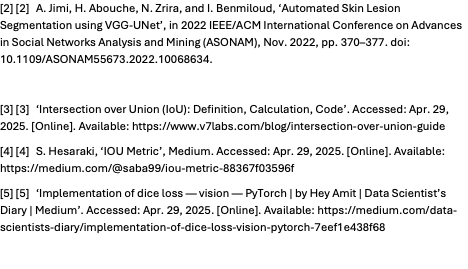